# Introduction

### Problem Description

It will be written soon.

### Software Requirements

(tensorflow)

# General Preparations

### Import Statements

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import r2_score

from tqdm import tqdm

### Data Extraction and Exploratory Analysis

In [2]:
ser = pd.read_csv('series_with_plateaus.csv', sep='\t')['value']
ser.head()

0    337.0
1    337.0
2    341.0
3    341.5
4    344.0
Name: value, dtype: float64

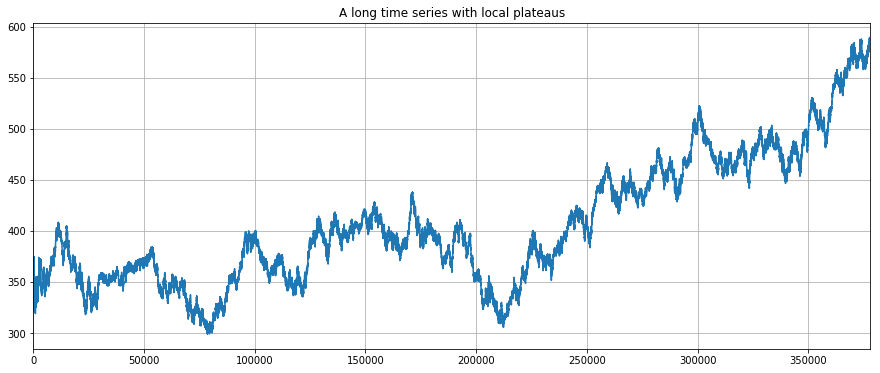

In [3]:
_ = ser.plot(figsize=(15, 6), grid=True,
             title='A long time series with local plateaus')

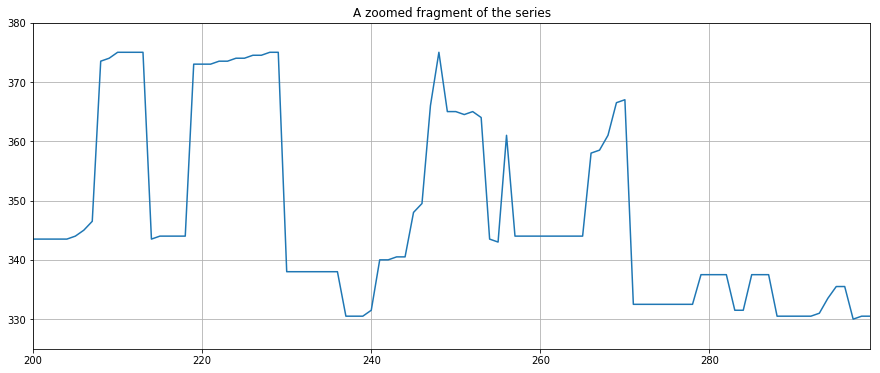

In [4]:
_ = ser[200:300].plot(figsize=(15, 6), grid=True, ylim=[325, 380],
                      title='A zoomed fragment of the series')

### Baseline model

What forecast quality can be achieved by a simple baseline model such as, say, MA(3)?

In [5]:
ma_preds = ser.shift().rolling(window=3, min_periods=1).mean()
ma_preds.iloc[0] = 0
ma_preds.head()

0      0.000000
1    337.000000
2    337.000000
3    338.333333
4    339.833333
Name: value, dtype: float64

In [6]:
r2_score(ser, ma_preds)

0.99980922101699699

Above score means that almost all variation of the series around its mean can be explained by MA(3). However, this is caused by slow changes in values rather than by outstanding performance of MA(3). Local variations around local means are not explained perfectly. Let us look at some examples.

In [7]:
r2_score(ser[-100:], ma_preds[-100:])

0.74662316000926254

In [8]:
r2_score(ser[-1100:-1000], ma_preds[-1100:-1000])

0.81838331324090685

Another important thing that should be noticed here, is that the above scores relate to multiple one-step-ahead forecasts. If there is a need to create a forecast with long horizon, MA(3) is not a good choice. To see this, split data to a "train" set (actually, MA(3) has no fitting) and a hold-out test set. 

In [9]:
train_test_frontier = int(round((3 / 4) * len(ser.index), 0))
train_test_frontier

283401

In [10]:
horizon = 100

100%|██████████| 94367/94367 [00:29<00:00, 3211.66it/s]


-2.0085900301932358

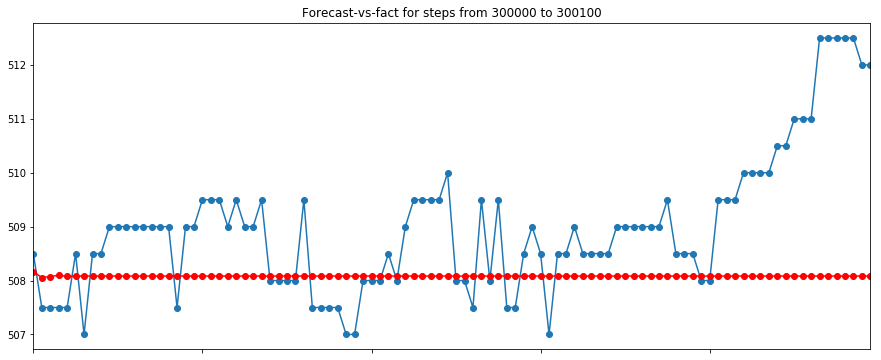

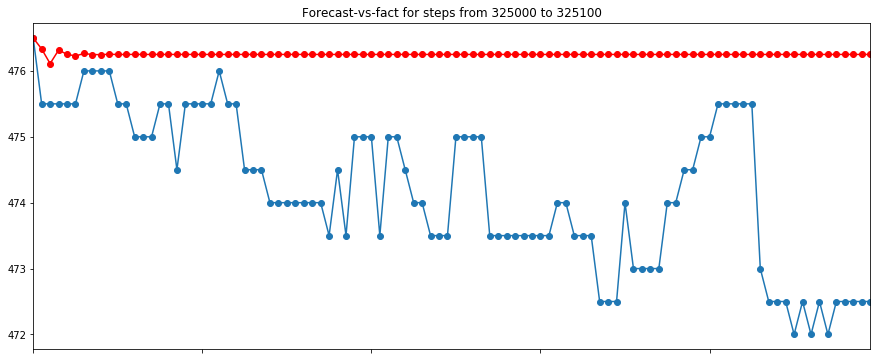

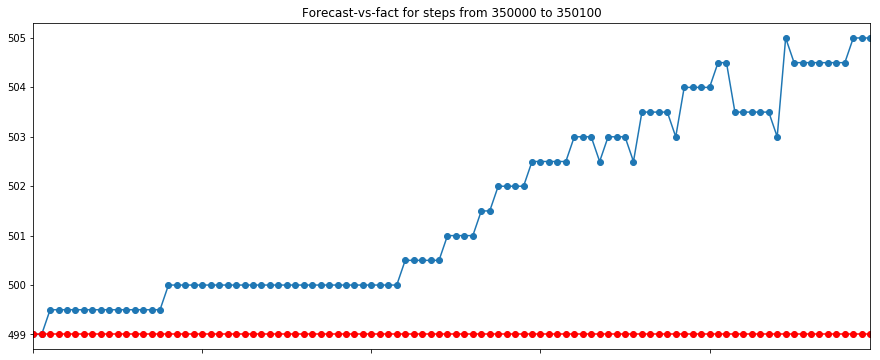

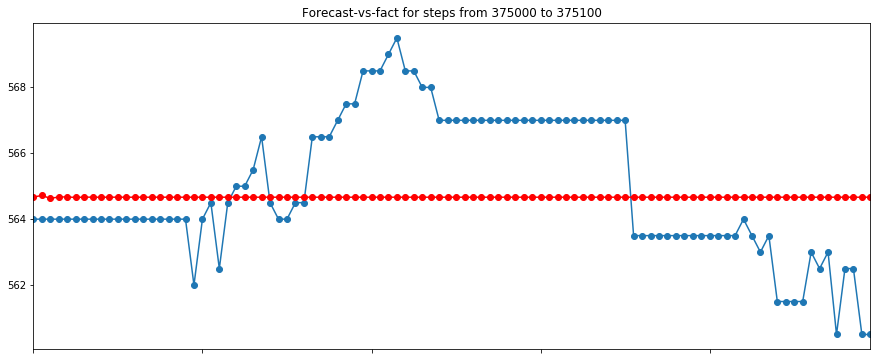

In [11]:
scores = []
for i in tqdm(range(train_test_frontier, len(ser.index) - horizon)):
    y_true = ser.iloc[i:(i + horizon)]
    y_hat = ser.iloc[(i - 3):i].tolist()
    for j in range(horizon):
        y_hat.append(sum(y_hat[-3:]) / 3)

    y_hat = y_hat[3:]
    score = r2_score(y_true, y_hat)
    scores.append(score)
    
    if i % 25000 == 0:
        fig = plt.figure(figsize=(15, 6))
        ax = fig.add_subplot(111)
        ax.set_title('Forecast-vs-fact for steps from {} to {}'.format(i, i + horizon))
        ax.set_xticklabels([])
        
        y_true.plot(ax=ax, marker='o')
        pd.Series(y_hat, index=y_true.index).plot(ax=ax, c='red', marker='o')

sum(scores) / len(scores)

Negative value of $R^2$ score is not a bug. As it can be seen, MA(3) predictions rapidly converge to a constant. If this constant is equal to mean of the corresponding slice from the true series, $R^2$ score is 0, because the model does not explain any variation around the mean. However, any constant that is not equal to the true mean, is worse than the true mean from MSE minimization point of view, and so $R^2$ coefficient of determination is even lower than 0, i.e. it is negative.

# Forecasting with bare LSTM